In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../data'
N_MODS = 3

Mutate: False


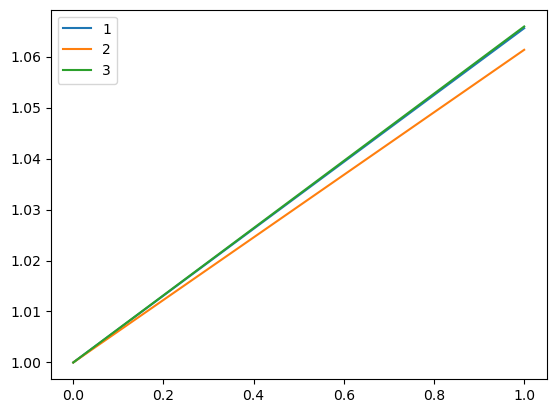

In [3]:
N_NEEDED = 9  # lengthen horizon only when best is the same as prev run

perf1 = np.array([
    110891,118162])
perf2 = np.array([
    110183,116941])
perf3 = np.array([
    109907,117151])

MUTATE = len(perf1) - 1 >= N_NEEDED
print('Mutate:', MUTATE)

buying_power = [  9537, 11638,  8649]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
1.1*.49005

0.5390550000000001

In [5]:
BEST = 2  # [1, 2, 3]
MUTATE_SCALE = 0.539055  # x0.9 or x1.1 decrease if same; incr if new

In [6]:
metrics = pd.read_csv(f'../daily/data/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAPL,210.789993,1,0.49040,0.50960,0.842084,0.240586,0.824978
1,ABNB,134.210007,1,0.92968,0.07032,0.954914,0.623350,0.210461
2,ACN,322.089996,1,0.82040,0.17960,0.990851,0.158577,0.668003
3,ADBE,395.940002,1,0.79360,0.20640,0.941925,0.146862,0.647944
4,AMD,108.120003,1,0.80720,0.19280,0.912092,0.344351,0.940068


In [7]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [8]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [9]:
len(states)

3

In [10]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [11]:
if MUTATE:
    print('mutating...')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [12]:
len(mods)

3

In [13]:
#for mod in mods:
#    print(mod.Ws)

In [14]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [15]:
holdings_files = sorted(
    [f for f in os.listdir('/Users/dsp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

/var/folders/b1/7f2d794n0s557s82crz_kn0r0000gn/T/ipykernel_283/4141980449.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
/var/folders/b1/7f2d794n0s557s82crz_kn0r0000gn/T/ipykernel_283/4141980449.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
/var/folders/b1/7f2d794n0s557s82crz_kn0r0000gn/T/ipykernel_283/4141980449.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True

,holdings1,holdings2,holdings3
stock,,,
AAON,1150.93,523.15,1150.93
AAPL,1686.32,1897.11,843.16
ABBV,570.21,570.21,760.28
ABNB,671.05,1342.10,1207.89
ABT,527.96,0.00,0.00


In [16]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 6)

In [21]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[221781.43, 220366.95, 219812.66999999998]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAPL,198.53,0.005809,0.006377,0.006109,1288.33,1405.21,1342.74
ABNB,127.04,0.006450,0.005386,0.006109,1430.56,1186.90,1342.74
ACN,307.90,0.005910,0.005951,0.006208,1310.67,1311.47,1364.67
ADBE,383.28,0.005923,0.005981,0.006166,1313.56,1317.99,1355.43
AMD,102.84,0.005927,0.006691,0.006580,1314.48,1474.45,1446.44


In [22]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAPL,198.53,0.005809,0.006377,0.006109,1288.33,1405.21,1342.74,1588.24,1786.77,794.12
ABNB,127.04,0.006450,0.005386,0.006109,1430.56,1186.90,1342.74,635.20,1270.40,1143.36
ACN,307.90,0.005910,0.005951,0.006208,1310.67,1311.47,1364.67,923.70,923.70,923.70
ADBE,383.28,0.005923,0.005981,0.006166,1313.56,1317.99,1355.43,1149.84,383.28,1149.84
AMD,102.84,0.005927,0.006691,0.006580,1314.48,1474.45,1446.44,1131.24,822.72,822.72


In [23]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAPL,198.53,0.005809,0.006377,0.006109,1288.33,1405.21,1342.74,1588.24,1786.77,794.12,-299.91,-381.56,548.62
ABNB,127.04,0.006450,0.005386,0.006109,1430.56,1186.90,1342.74,635.20,1270.40,1143.36,795.36,-83.50,199.38
ACN,307.90,0.005910,0.005951,0.006208,1310.67,1311.47,1364.67,923.70,923.70,923.70,386.97,387.77,440.97
ADBE,383.28,0.005923,0.005981,0.006166,1313.56,1317.99,1355.43,1149.84,383.28,1149.84,163.72,934.71,205.59
AMD,102.84,0.005927,0.006691,0.006580,1314.48,1474.45,1446.44,1131.24,822.72,822.72,183.24,651.73,623.72


In [24]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [25]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAPL,198.53,0.005809,0.006377,0.006109,1288.33,1405.21,1342.74,1588.24,1786.77,794.12,-299.91,-381.56,548.62,-2,-2,3
ABNB,127.04,0.006450,0.005386,0.006109,1430.56,1186.90,1342.74,635.20,1270.40,1143.36,795.36,-83.50,199.38,6,-1,2
ACN,307.90,0.005910,0.005951,0.006208,1310.67,1311.47,1364.67,923.70,923.70,923.70,386.97,387.77,440.97,1,1,1
ADBE,383.28,0.005923,0.005981,0.006166,1313.56,1317.99,1355.43,1149.84,383.28,1149.84,163.72,934.71,205.59,0,2,1
AMD,102.84,0.005927,0.006691,0.006580,1314.48,1474.45,1446.44,1131.24,822.72,822.72,183.24,651.73,623.72,2,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTRS,8.77,0.006461,0.005650,0.006109,1432.88,1245.15,1342.74,0.00,710.37,973.47,1432.88,534.78,369.27,163,61,42
WING,267.34,0.005986,0.006710,0.006546,1327.64,1478.61,1438.88,1069.36,1069.36,1069.36,258.28,409.25,369.52,1,2,1
WIT,2.82,0.006461,0.005433,0.006109,1432.86,1197.34,1342.74,795.24,1164.66,831.90,637.62,32.68,510.84,226,12,181


<span style="color: red">CHECK URL!</span>

In [26]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(5)

,price,diff1,shares1
stock,,,
GRAB,4.90,1433.86,293
CPNG,26.00,1433.82,55
PATH,12.50,1433.65,115
VTRS,8.77,1432.88,163
BABA,125.33,1225.16,10


In [28]:
o[o.shares1 != 0].tail(5)

,price,diff1,shares1
stock,,,
PGR,284.51,-390.43,-1
GRMN,191.43,-427.75,-2
SMLR,34.79,-436.66,-13
BLD,295.26,-473.50,-2
SERV,7.46,-506.74,-68


<span style="color: red">SERIOUSLY....</span></br>
<span style="color: red">CHECK URL!</span>

In [29]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(5)

,price,diff2,shares2
stock,,,
CEG,271.37,1349.17,5
PATH,12.50,1290.67,103
EEM,44.91,1270.44,28
MIY,11.69,1238.56,106
NVDA,116.65,1189.55,10


In [30]:
o[o.shares2 != 0].tail(5)

,price,diff2,shares2
stock,,,
GRMN,191.43,-923.38,-5
PG,157.66,-923.42,-6
LGIH,55.31,-956.24,-17
MASI,156.57,-1009.68,-6
QBTS,11.09,-1039.12,-94


In [32]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(5)

,price,diff3,shares3
stock,,,
META,592.49,812.11,1
GLD,306.84,811.98,3
AMT,219.97,733.76,3
JNJ,154.22,720.58,5
NLR,84.48,699.04,8


In [33]:
o[o.shares3 != 0].tail(5)

,price,diff3,shares3
stock,,,
AMZN,193.06,-119.71,-1
NET,132.34,-143.81,-1
BROS,63.43,-179.58,-3
GRMN,191.43,-188.78,-1
QBTS,11.09,-597.24,-54


In [27]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

Did nothing
